# Problem-Specific Coordinate Generation for HyperNEAT Substrates

## Setup

The testing was done on a 16GB VRAM GPU with CUDA 12.8. VRAM usage is determined mainly by substrate and population size.

### Imports

This setup requires some dependencies, mainly TensorNEAT, JAX, numpy, matplotlib, NetworkX, scikit-learn and wandb for logging. Using a virtual environment (i.e. conda) is highly recommended. Python 3.10.18 was used in development and testing.

In [1]:
import jax
import numpy as np
import wandb
import matplotlib.pyplot as plt
from collections import defaultdict

from config import config
from tensorneat.algorithm.hyperneat import FullSubstrate

from substrate_generation.pca_coor_generator import PCAanalyzer 
from substrate_generation.pca_inv_coor_generator import InvPCAanalyzer 
from substrate_generation.sdl_coor_generator import SparseDictionaryAnalyzer
from substrate_generation.fa_coor_generator import FactorAnalyzer
from substrate_generation.manual_coor_generator import ManualIOMapper
from substrate_generation.random_coor_generator import RandomCoordinateGenerator
from substrate_generation.data_sampling import collect_random_policy_data, collect_trained_agent_policy_data
from evol_pipeline.brax_env import CustomBraxEnv
from evol_pipeline.custom_pipeline import CustomPipeline
from evol_pipeline.custom_substrate import AutoLayeredCoordMLPSubstrate
from substrate_generation.hidden_layers import HiddenLayerGenerator
from utils.visualization import visualize_cppn, visualize_nn, display_plots_side_by_side
from utils.utils import save_coordinates_to_csv, setup_folder_structure
from evol_pipeline.evol_algorithm import create_evol_algorithm

A quick setup of the folder structure to avoid errors further down the line.

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir"]
setup_folder_structure(OUTPUT_DIR)

### Setup Environment

[Brax environments](https://github.com/google/brax/tree/main/brax/envs) are used for this experiment through the [TensorNEAT wrapper](https://github.com/EMI-Group/tensorneat/tree/main/src/tensorneat/problem/rl).

In [3]:
env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=False,
    sample_episodes=16,
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]
feature_dims = config["data_analysis"]["feature_dims"]

print("env_problem.input_shape: ", env_problem.input_shape)
print("env_problem.input_shape: ", env_problem.output_shape)

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-10-05 12:54:25.454105: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-05 12:54:36.265538: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by usin

env_problem.input_shape:  (27,)
env_problem.input_shape:  (8,)


## Data Sampling

Before we can apply data-driven approaches to the task of substrate generation, some data needs to be generated. This can either be done by generating random action or actually training an agent for a short period and then sampling from its action. Both data sampling methods are used for comparison.

### Data Sampling Method 1: Trained Agent

First, we train an number of agents for a few generations on a simple substrate for the sole purpose of sampling their actions.


In [4]:
key = jax.random.PRNGKey(config["experiment"]["seed"])
num_trained_agent_sampling = config["data_sampling"]["num_agents_to_sample"]
all_trained_agent_data = []
for i in range(num_trained_agent_sampling):
    print(f"\nTraining and sampling agent #{i+1}/{num_trained_agent_sampling}")
    key, subkey = jax.random.split(key)
    trained_agent_data_run = collect_trained_agent_policy_data(
        env_problem=env_problem,
        key=subkey,
        num_steps=config["data_sampling"]["sampling_steps"],
    )
    all_trained_agent_data.append(trained_agent_data_run)

combined_trained_agent_data = np.vstack(all_trained_agent_data)

print(f"Data collection complete. Combined data from {num_trained_agent_sampling} trained agents.")
print(f"Shape of each run's data: {all_trained_agent_data[0].shape}")
print(f"Shape of combined trained agents data: {combined_trained_agent_data.shape}")



Training and sampling agent #1/1

Starting Agent Training and Data Collection
Configuring and training the agent...
Query dimension for sampling:  4
initializing
initializing finished
start compile


XlaRuntimeError: INTERNAL: cuSolver internal error

### Data Sampling Method 2: Random Policy

Now, we will sample data from the environment with a random action policy.

In [ ]:
key, random_key = jax.random.split(key)
num_random_sampling_steps = num_trained_agent_sampling * config["data_sampling"]["sampling_steps"]
random_data = collect_random_policy_data(env_problem, random_key, num_random_sampling_steps)

Starting data collection for 1000 steps using a random policy...
Causal data collection finished.


In [ ]:
data_sources = {
    "trained": combined_trained_agent_data,
    "random": random_data
}

generated_io_coors = defaultdict(lambda: defaultdict(dict))

## Data Analysis

Next, it's time to analyse the sampled data. The goal is to find correlations in the data which can be used to assign substrate coordinates. Again, different methods are used for comparison, namely Principal Component Analysis (PCA), Factor Analysis (FA) and Sparse Dictionary Learning (SDL). These methods will be applied to both data samples.

In this first step, the analysis methods will be used to produce input and output coordinates only. The hidden layers are generated later.

### PCA

Principal Component Analysis (PCA) is commonly used for dimensionality reduction and using Singular Value Decomposition of the data to project it to a lower dimensional space. The [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of PCA is used here.

Analyzing trained sampling data
Running PCA to find feature dimensions covering 65.0% of variance (with a hard limit of 8 dimensions)...
PCA found 2 dimensions needed for 65.0% variance.
Applying max limit. Final number of feature dimensions: 2
Normalizing coordinates...
Added layering dimension. Final coordinate size: 3
PCA variance plot saved to: output/ant/data_analysis/pca_variance_65_trained.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_65_trained.png


Analyzing trained sampling data
Running PCA to find feature dimensions covering 99.0% of variance (with a hard limit of 8 dimensions)...
PCA found 18 dimensions needed for 99.0% variance.
Applying max limit. Final number of feature dimensions: 8
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
PCA variance plot saved to: output/ant/data_analysis/pca_variance_99_trained.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_99_trained.png


Analyzi

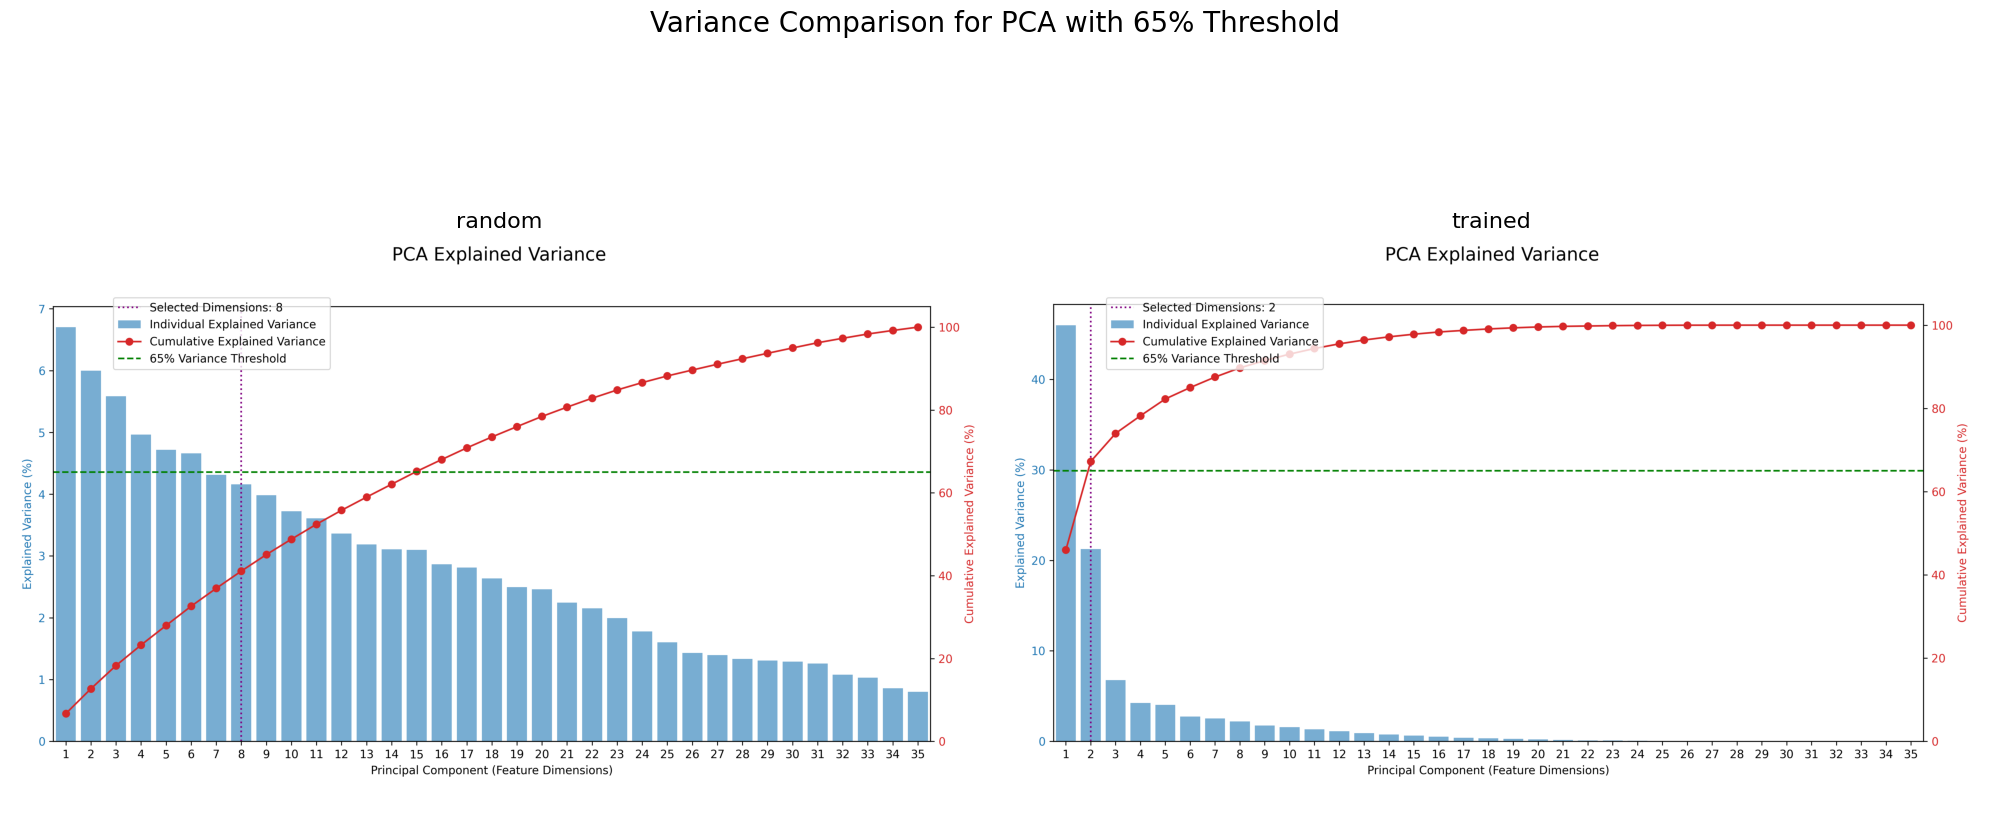

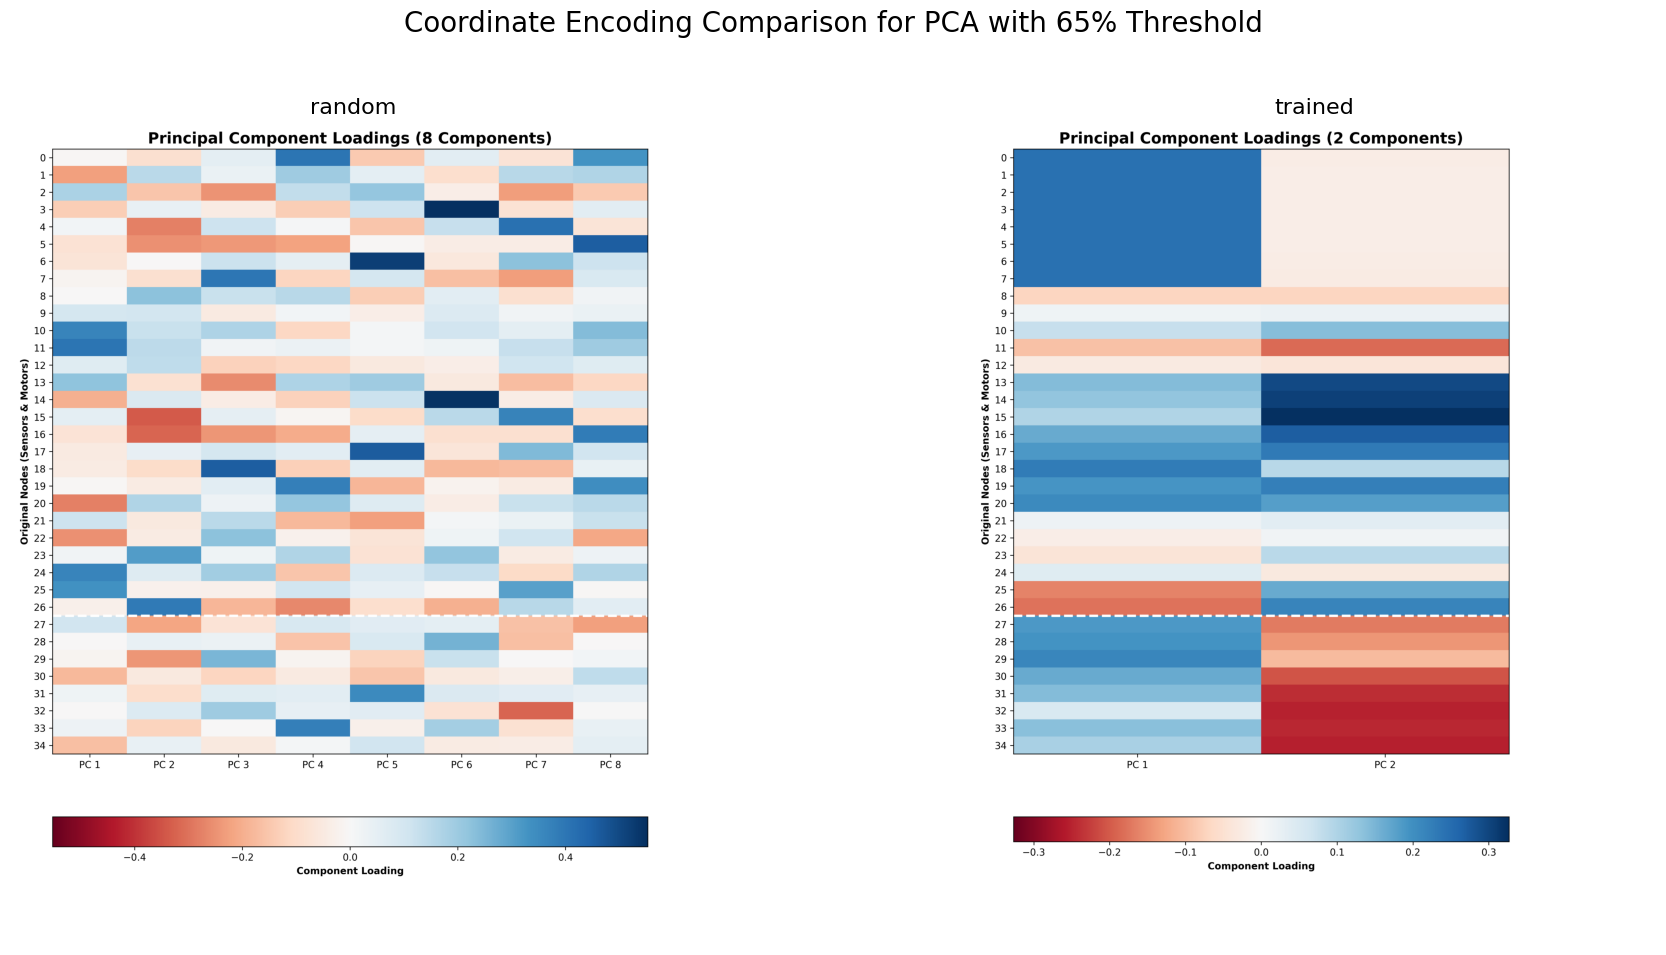

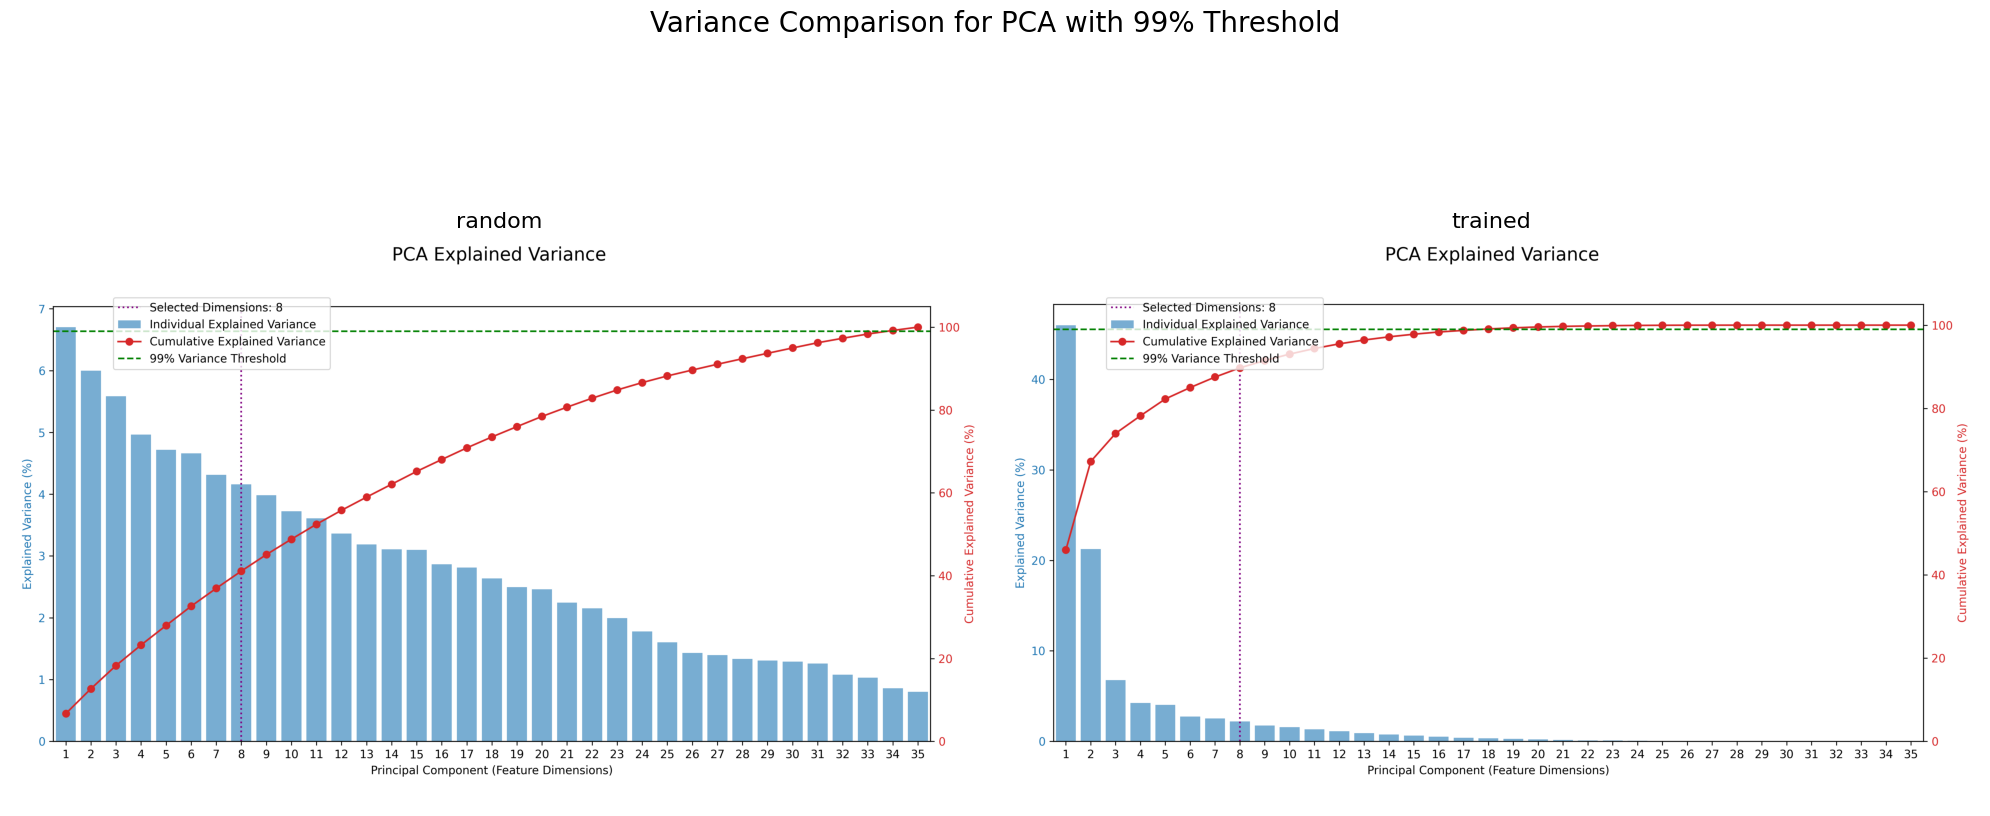

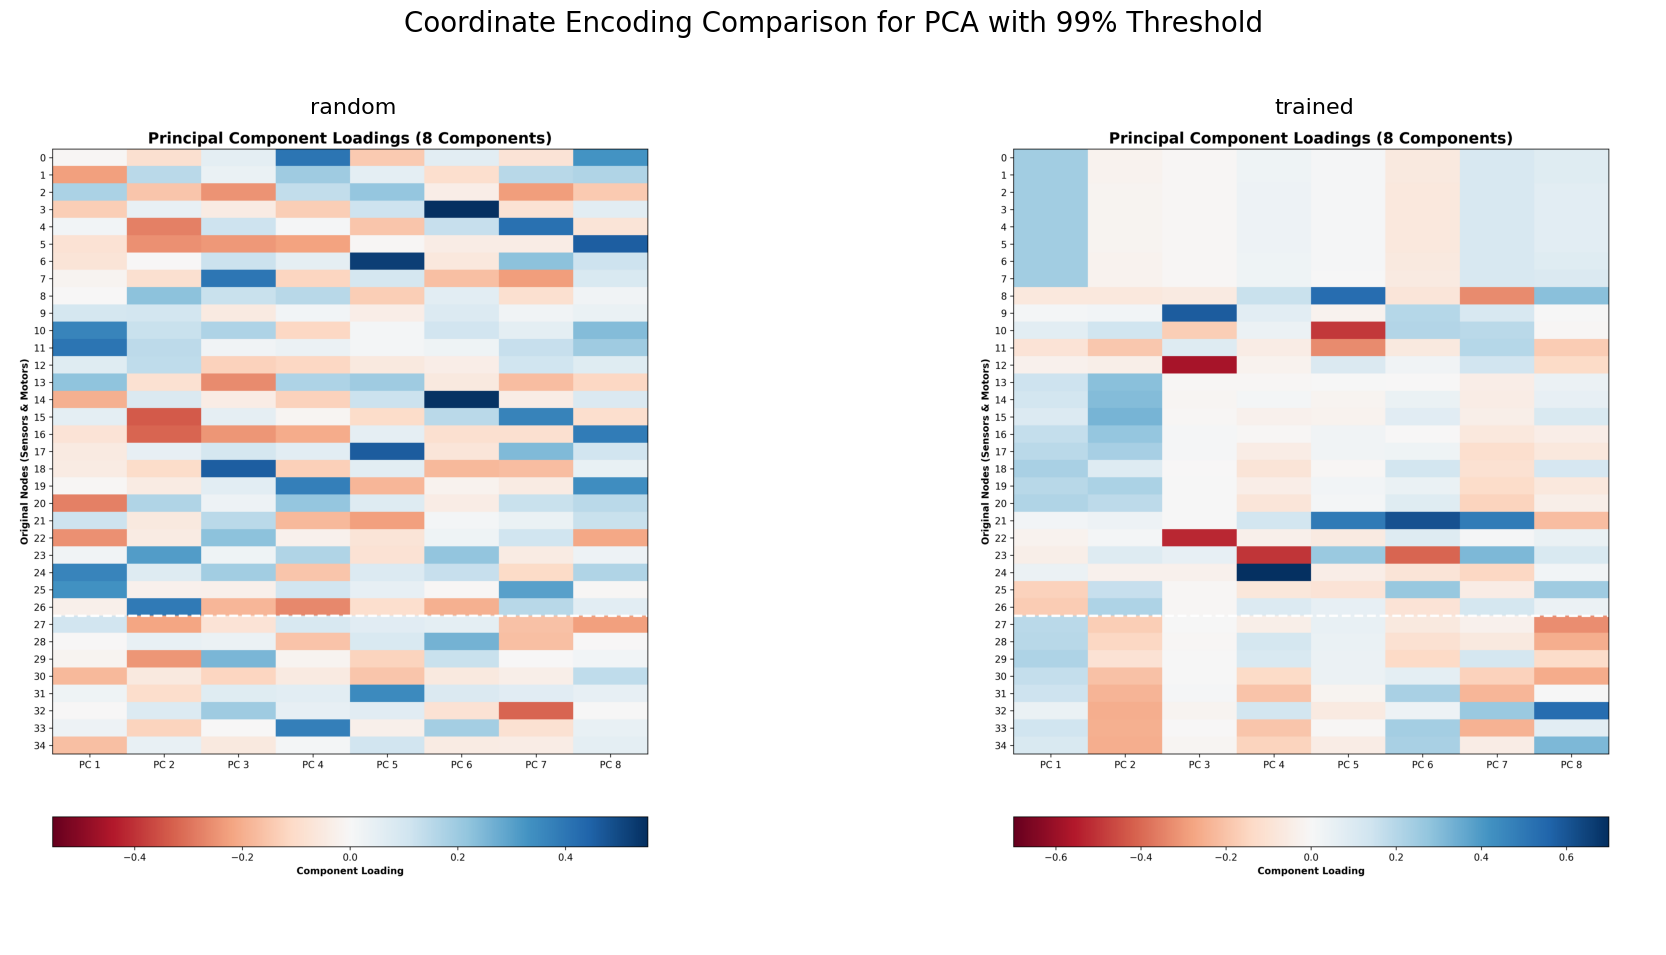

In [ ]:
pca_variances = [config["data_analysis"]["variance_threshold"], 0.99]

for data_label, data_array in data_sources.items():
    for variance in pca_variances:
        percentage = int(variance*100)
        print(f"Analyzing {data_label} sampling data")
        analyzer_pca = PCAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            variance_threshold=variance, 
            feature_dims=feature_dims,
            hidden_depth=config["substrate"]["hidden_depth"],
            width_factor=config["substrate"]["width_factor"],
            normalize_coors=config["data_analysis"]["normalize_coors"],
            depth_factor=config["substrate"]["depth_factor"],
        )
        input_coors_pca, output_coors_pca = analyzer_pca.generate_io_coordinates()
        generated_io_coors[data_label][f"pca{percentage}"]["input_coors"] = input_coors_pca
        generated_io_coors[data_label][f"pca{percentage}"]["output_coors"] = output_coors_pca
        analyzer_pca.plot_variance(save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_{data_label}.png")
        analyzer_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_{data_label}.png")
        print("\n")

for variance in pca_variances:
    percentage = int(variance*100)
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Variance Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_comparison.png"
    )
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate Encoding Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_comparison.png"
)

To measure the effect of PC selection by variance, another baseline with inversed variance selection is established. It means that in this case, the PCs with the least variance are chosen for coordinate generation.

Analyzing trained sampling data with PCA
Running inverse PCA to find 8 feature dimensions covering least variance...
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
Inverse PCA variance plot saved to: output/ant/data_analysis/inv_pca_trained.png
Principal component heatmap saved to: output/ant/data_analysis/inv_pca_heatmap_trained.png


Analyzing random sampling data with PCA
Running inverse PCA to find 8 feature dimensions covering least variance...
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
Inverse PCA variance plot saved to: output/ant/data_analysis/inv_pca_random.png
Principal component heatmap saved to: output/ant/data_analysis/inv_pca_heatmap_random.png




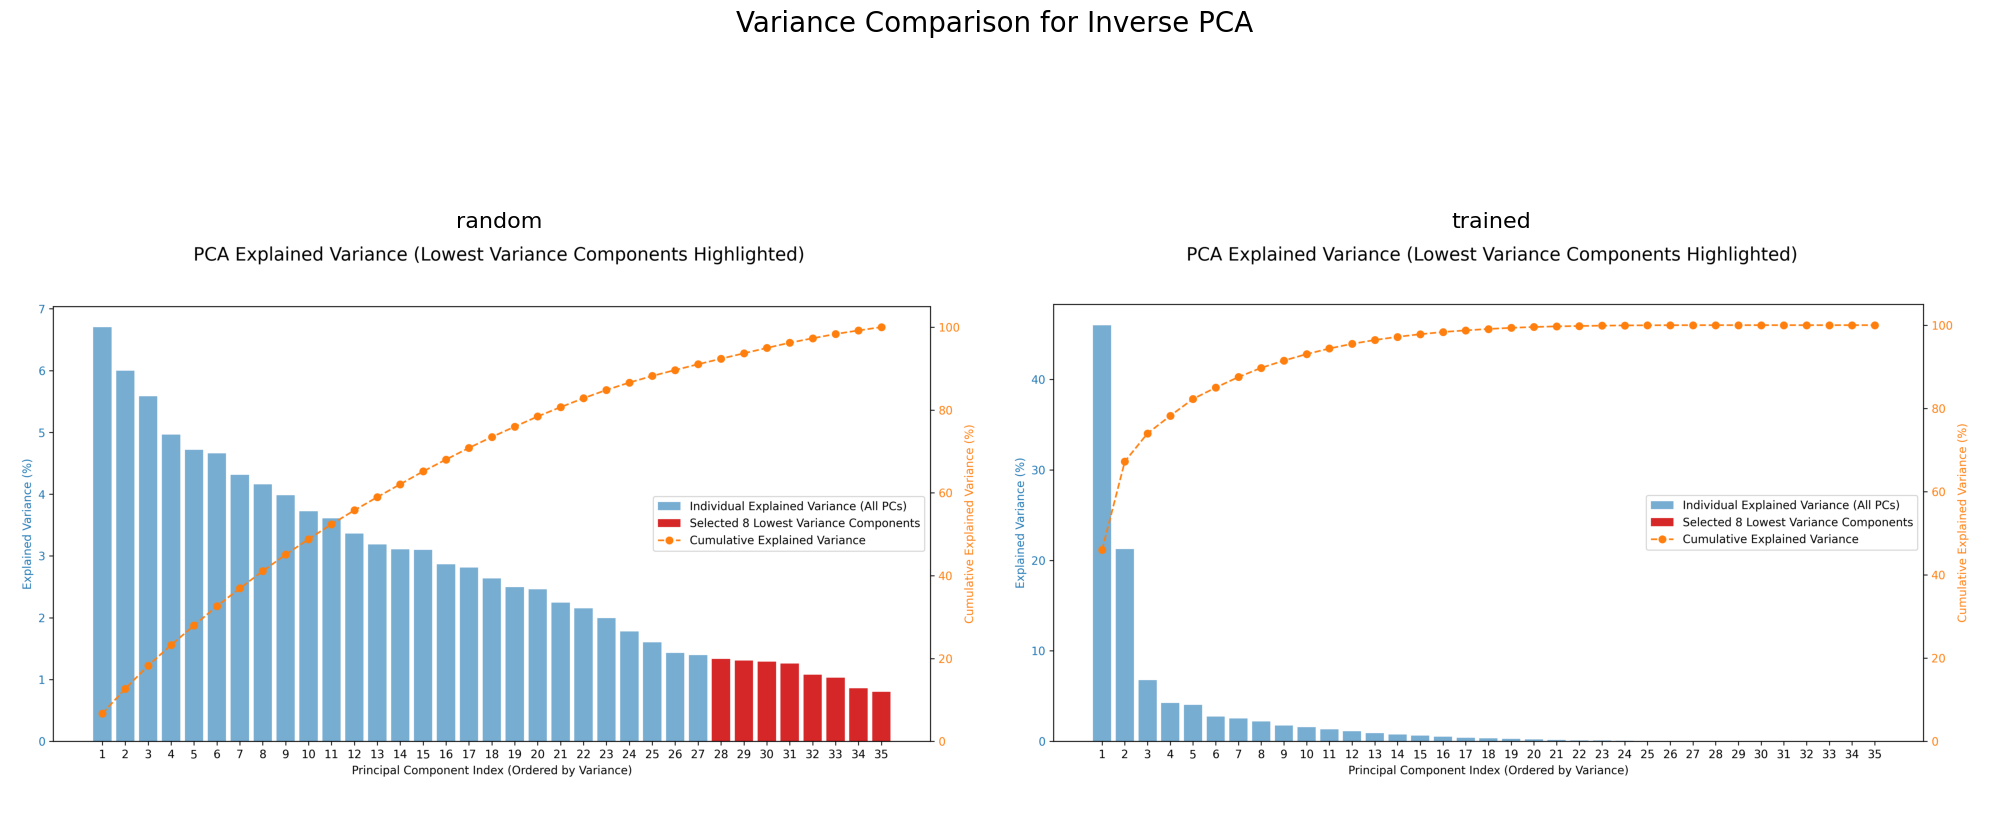

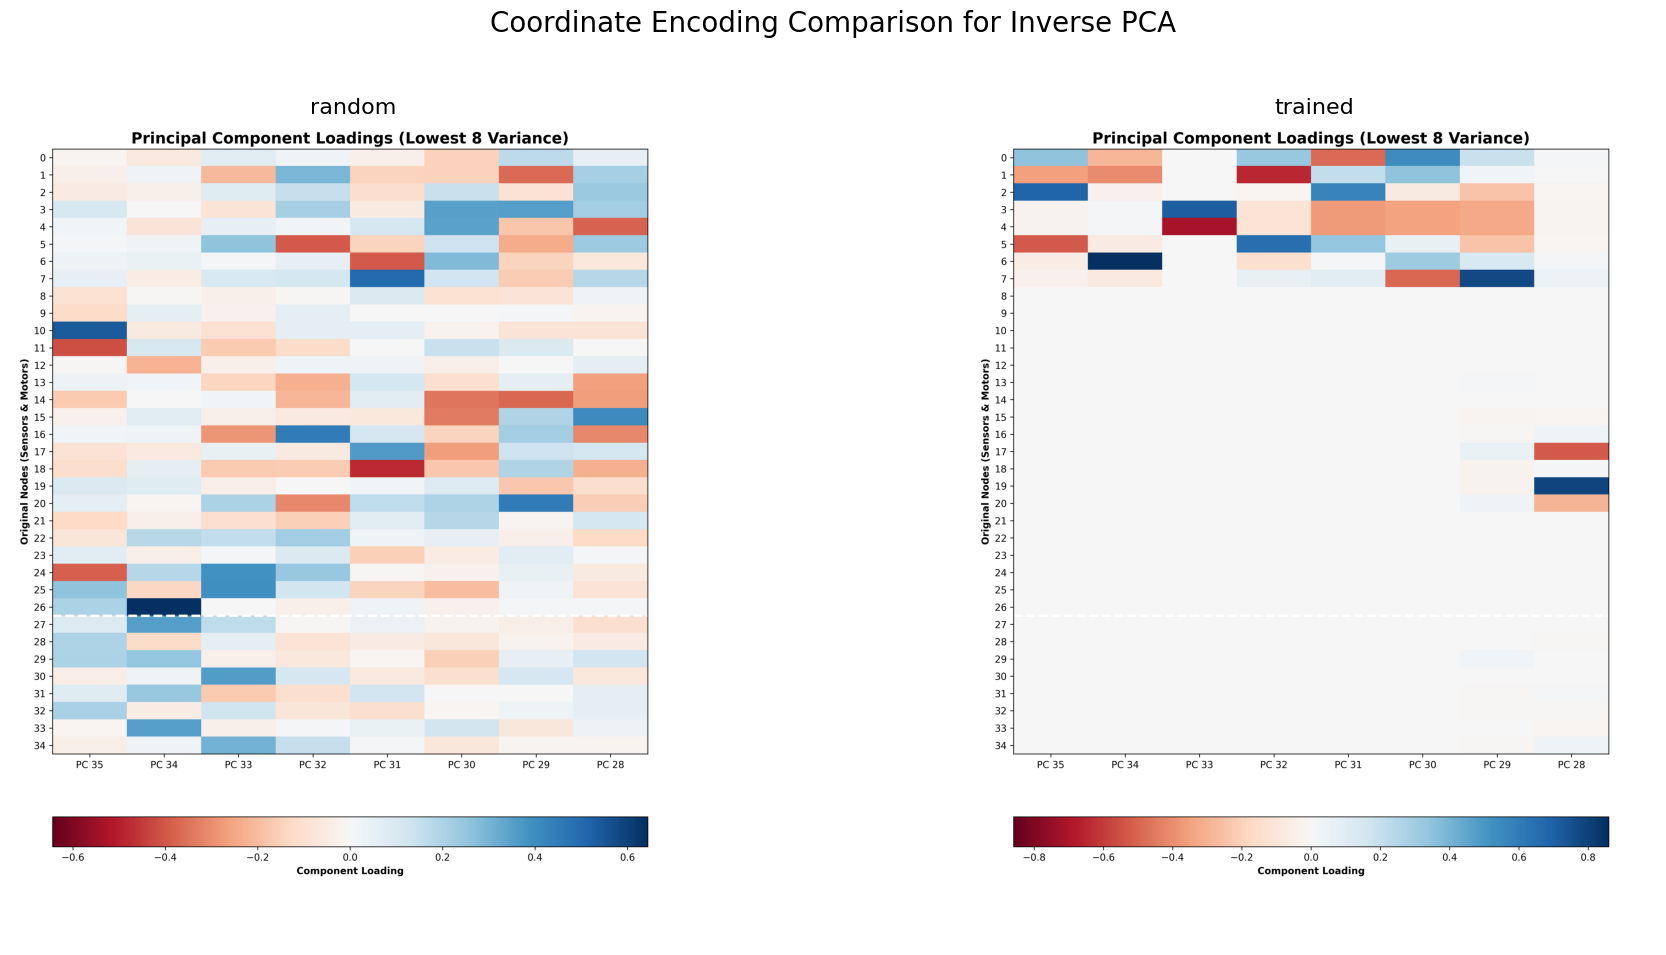

In [ ]:
for data_label, data_array in data_sources.items():
    percentage = int(variance*100)
    print(f"Analyzing {data_label} sampling data with PCA")
    analyzer_inv_pca = InvPCAanalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        feature_dims=feature_dims,
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"],
        normalize_coors=config["data_analysis"]["normalize_coors"],
        depth_factor=config["substrate"]["depth_factor"],
    )
    input_coors_inv_pca, output_coors_inv_pca = analyzer_inv_pca.generate_io_coordinates()
    generated_io_coors[data_label][f"inv_pca"]["input_coors"] = input_coors_inv_pca
    generated_io_coors[data_label][f"inv_pca"]["output_coors"] = output_coors_inv_pca
    analyzer_inv_pca.plot_least_variance_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_{data_label}.png")
    analyzer_inv_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_{data_label}.png")
    print("\n")

percentage = int(variance*100)
display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_random.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Variance Comparison for Inverse PCA",
    save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_variance_comparison.png"
)
display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Coordinate Encoding Comparison for Inverse PCA",
    save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_comparison.png"
)

### Factor Analysis

Next, the data is analysed through factor analysis.

Analyzing trained sampling data
Running Factor Analysis to find 8 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
Factor loadings heatmap saved to: output/ant/data_analysis/fa_heatmap_trained.png


Analyzing random sampling data
Running Factor Analysis to find 8 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
Factor loadings heatmap saved to: output/ant/data_analysis/fa_heatmap_random.png




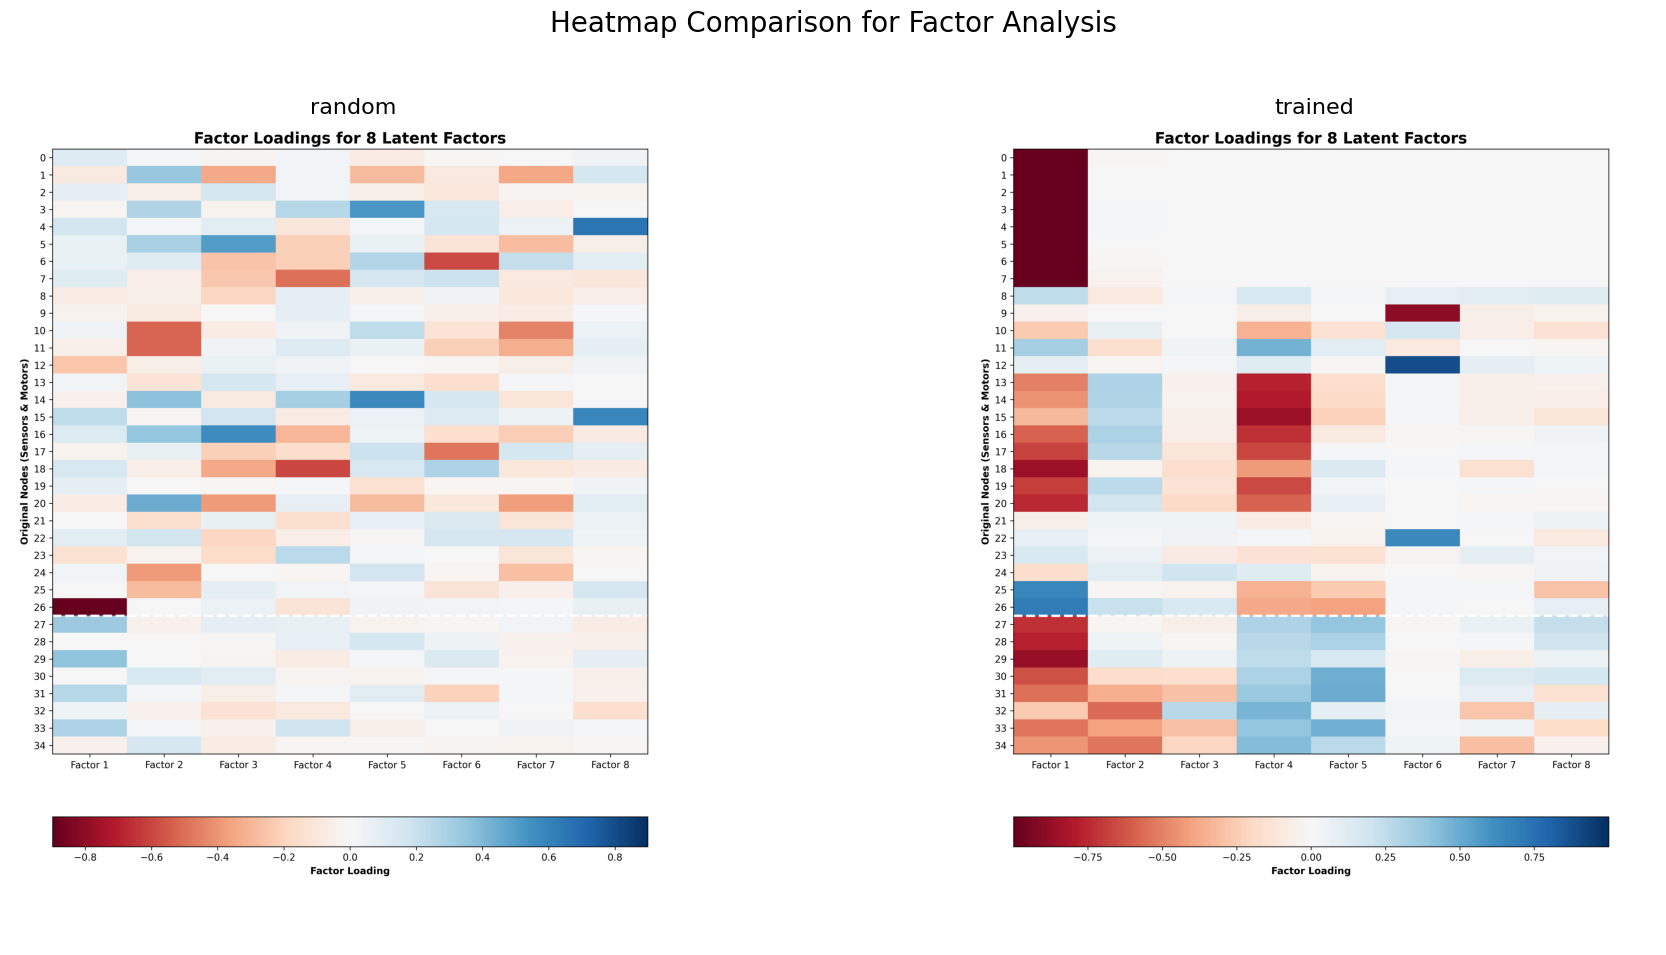

In [ ]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_fa = FactorAnalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        feature_dims=feature_dims,
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"],
        normalize_coors=config["data_analysis"]["normalize_coors"],
        depth_factor=config["substrate"]["depth_factor"],
    )
    input_coors_fa, output_coors_fa = analyzer_fa.generate_io_coordinates()
    generated_io_coors[data_label]["fa"]["input_coors"] = input_coors_fa
    generated_io_coors[data_label]["fa"]["output_coors"] = output_coors_fa
    analyzer_fa.plot_factor_loadings(save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/fa_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/fa_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for Factor Analysis",
    save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_comparison.png"
)

### Sparse Dictionary Learning

Lastly, Sparse Dictionary Learning is also applied to the data.

Analyzing trained sampling data
Running Sparse Dictionary Learning to find 8 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
Dictionary atoms heatmap saved to: output/ant/data_analysis/sdl_heatmap_trained.png


Analyzing random sampling data
Running Sparse Dictionary Learning to find 8 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Normalizing coordinates...
Added layering dimension. Final coordinate size: 9
Dictionary atoms heatmap saved to: output/ant/data_analysis/sdl_heatmap_random.png




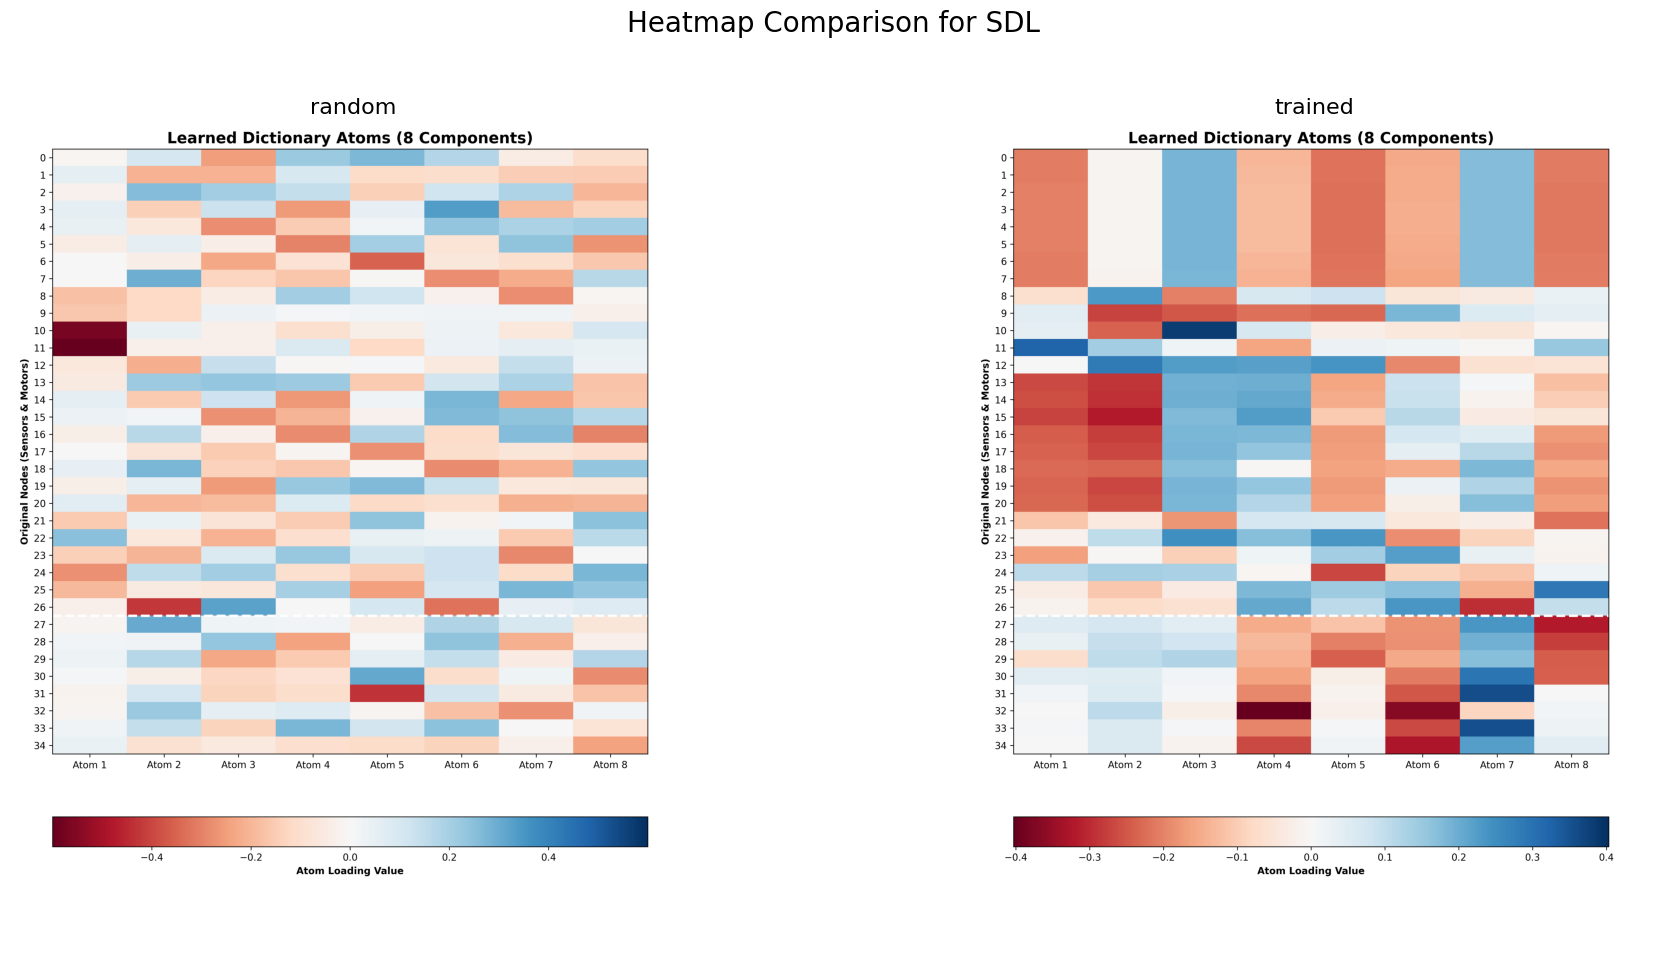

In [ ]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_sdl = SparseDictionaryAnalyzer(
        data=data_array,
        obs_size=obs_size,
        act_size=act_size,
        feature_dims=feature_dims,
        alpha=config["data_analysis"]["sdl_alpha"],
        max_iter=config["data_analysis"]["sdl_max_iter"],
        hidden_depth=config["substrate"]["hidden_depth"],
        width_factor=config["substrate"]["width_factor"],
        normalize_coors=config["data_analysis"]["normalize_coors"],
        depth_factor=config["substrate"]["depth_factor"],
    )
    input_coors_sdl, output_coors_sdl = analyzer_sdl.generate_io_coordinates()
    generated_io_coors[data_label]["sdl"]["input_coors"] = input_coors_sdl
    generated_io_coors[data_label]["sdl"]["output_coors"] = output_coors_sdl
    analyzer_sdl.plot_dictionary_atoms(save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for SDL",
    save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_comparison.png"
)

## Substrate Generation

Now it's time to generate the full substrates. The input and ouput nodes have already been generated above, so the hidden layers are the crucial part that's missing.

### Generating Hidden Layers

A `HiddenLayerGenerator` class is used to generate hidden nodes from the input node. There are of course, many ways these hidden nodes can be defined in the high-dimensional space. The class has a few options hard-coded:

* `one_hot_binary`: This does a one-hot encoding of the dimensions, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1)
* `one_hot_ternary`: This does a one-hot encoding of the dimensions which also includes negatives, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1),(-1,0,0),(0,-1,0),(0,0,-1)
* `one_double_hot_binary`: This is the same as one-hot, but has two coordinates in every dimension, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2)
* `two_hot_binary`: This adds all possible pairs of dimensions as coordinates to the one_hor ecoding, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1)
* `shift`: This schema takes all input nodes and simply "shifts" every one of them into the layering direction by 1 for each layer.
* `shift_two_out`: This does the same as `shift`, but doubles the number of nodes by adding duplicates outside the bounds of the original nodes by adding the width_factor which determines the outer bounds of the dimensions.
* `shift_three_out`: This does the same as `shift_double_out`, but adds another set of duplicates of the original nodes with double the distance than before.
* `shift_two_in`: This does the same as `shift`, but doubles the number of nodes by adding duplicates inside the bounds of the original nodes by dividing the coordinates in each dimension by 2.
* `shift_three_in`: This does the same as `shift_double_in`, but adds another set of duplicates of the original where the nodes in each dimension are positioned at 1/3, 2/3 and full distance.

So `shift_*_in` increases the resolution while `shift_*_out` extends the network outwards.

One important thing to notice is that the number of generated hidden nodes is highly dependent on the number of dimensions (one_hot/one_double_hot linear and two_hot exponential), except for the `shift`-based methods.

In [ ]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
    depth_factor=config["substrate"]["depth_factor"],
    width_factor=config["substrate"]["width_factor"],
)

substrates = defaultdict(lambda: defaultdict(dict))

### Simple Baseline Substrates

Before the data-driven approchaes are applied, some baselines are needed. The first one is a very simple 2D grid. This is the basic baseline in the sense of a "vanilla" HyperNEAT algorithm.

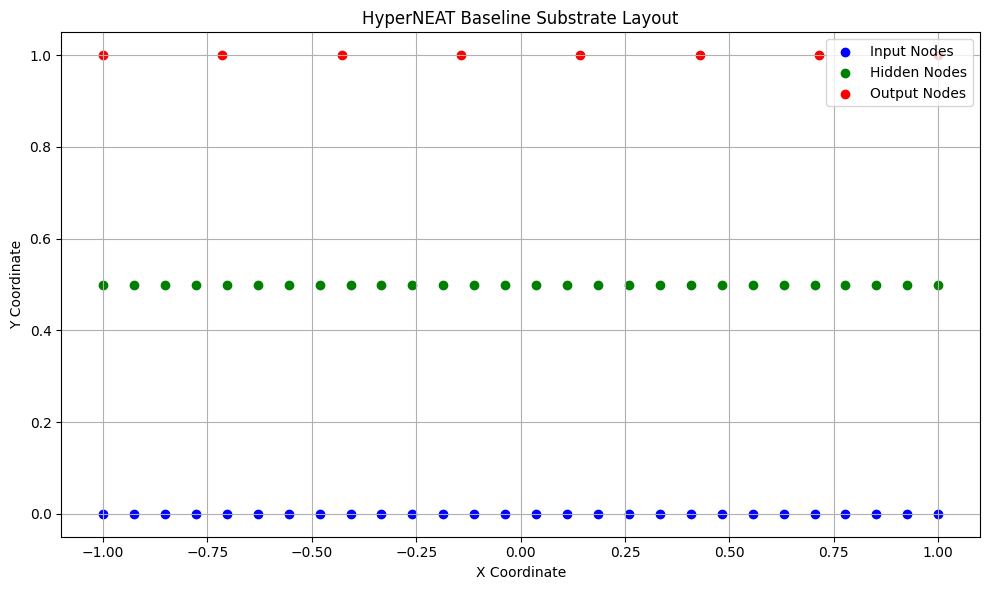

In [ ]:
width_factor = config["substrate"]["width_factor"]
hidden_depth = config["substrate"]["hidden_depth"]
depth_factor = config["substrate"]["depth_factor"]

# Input nodes (including bias) spaced horizontally from -1 to 1 at y = 0
input_coors_simple = [(((i / (obs_size) * 2 - 1)*width_factor), 0) for i in range(obs_size+1)]

# Use hidden node generator
hidden_coors_simple = hidden_layer_gen.get_hidden_coors(input_coors=input_coors_simple)

# Output neurons spaced out evenly horizontally at y=(1*depth_factor)
output_coors_simple = [(((i / (act_size - 1) * 2 - 1)*width_factor), (depth_factor)) for i in range(act_size)]

substrates["manual"]["simple"]["substrate"] = FullSubstrate(
    input_coors=input_coors_simple,
    hidden_coors=hidden_coors_simple,
    output_coors=output_coors_simple,
)

substrates["manual"]["simple"]["input_coors"] = input_coors_simple
substrates["manual"]["simple"]["hidden_coors"] = hidden_coors_simple
substrates["manual"]["simple"]["output_coors"] = output_coors_simple

plt.figure(figsize=(10, 6))

# Plot each layer with different colors
x, y = zip(*input_coors_simple)
plt.scatter(x, y, c='blue', label='Input Nodes')
x, y = zip(*hidden_coors_simple)
plt.scatter(x, y, c='green', label='Hidden Nodes')
x, y = zip(*output_coors_simple)
plt.scatter(x, y, c='red', label='Output Nodes')

plt.title('HyperNEAT Baseline Substrate Layout')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/baseline_substrate")
plt.show()

### Random Substrate

We also want to test if our data-driven approaches are better than arbritarily chosen coordinates in an equally high-dimensional space. For this purpose the generator creates a substrate with the given number of dimensions in which all coordinates are random binary combinations, e.g. (0,1,0,1,1,0). If the target number of coordinates can't be created from unique binary combinations, the generator uses terniary combinations of 0, 0.5, 1. If that also fails to generate the required number of coordinates, if falls back to continous random numbers.

In [ ]:
random_generator = RandomCoordinateGenerator(
    obs_size=obs_size,
    act_size=act_size,
    feature_dims=feature_dims,
    depth_factor=config["substrate"]["depth_factor"],
    width_factor=config["substrate"]["width_factor"],
)
input_coors_random, output_coors_random = random_generator.generate_io_coordinates()
generated_io_coors["manual"]["randomized"]["input_coors"] = input_coors_random
generated_io_coors["manual"]["randomized"]["output_coors"] = output_coors_random

Generating random coordinates with 8 feature dimensions...
Using binary alphabet [0, 1] for 27 coordinates.
Using binary alphabet [0, 1] for 8 coordinates.
Added layering dimension. Final coordinate size: 9


ValueError: too many values to unpack (expected 2)

### Substrate from Manual Mapping

The next baseline represents a substrate which is "hand-crafted" by a human expert.

A `ManualInputMapper` class creates substrate coordinates from a mapping of semantically meaningful categories such as "front", "back", "velocity", "angle". Every substrate node can be sorted into multiple categories. One of multiple categories form a dimension. E.g. "angle" might be a single dimension on its own whereas "front" and "back" are two opposite directions in the same dimension. Accordingly every category maps to a vector in the respective dimension. Applying all the vectors for a node, e.g. "front", "left", "hip" and "angular velocity" for the input node "angular velocity of the front left hip", generates the coordinate (0, 0, 1, 0, 0, 0, 0, -1, 1, 1, 0, 0).

The manual mappings are are implemented for the following [Brax environments](https://github.com/google/brax/tree/main/brax/envs):
* ant
* halfcheetah
* swimmer

In [ ]:
manual_mapper = ManualIOMapper(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    width_factor=config["substrate"]["width_factor"],
    depth_factor=config["substrate"]["depth_factor"],
)
input_coors_manual, output_coors_manual = manual_mapper.generate_io_coordinates()
generated_io_coors["manual"]["mapping"]["input_coors"] = input_coors_manual
generated_io_coors["manual"]["mapping"]["output_coors"] = output_coors_manual

Using user-defined input and output mapping for 'ant'.
Number of feature dimensions: 10
Total number after adding output and layering dimensions (coord_size): 12
Number of output nodes: 8
Number of input nodes (obs + bias): 28


### Substrate from Data Analysis Results

Next, the input and output nodes created through data analysis are used to create substrates.

In [ ]:
for data_label, data_dict in generated_io_coors.items():
    for method_label, method_dict in data_dict.items():

        input_coors = method_dict["input_coors"]
        output_coors = method_dict["output_coors"]
        hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)
        generated_io_coors[data_label][method_label]["hidden_coors"] = hidden_coors

        substrates[data_label][method_label]["substrate"] = FullSubstrate(
            input_coors=input_coors,
            hidden_coors=hidden_coors,
            output_coors=output_coors
        )

        substrates[data_label][method_label]["input_coors"] = input_coors
        substrates[data_label][method_label]["hidden_coors"] = hidden_coors
        substrates[data_label][method_label]["output_coors"] = output_coors

## Neuroevolution

Finally the substrates are ready to be used for neuroevolution with HyperNEAT. Weights and Biases (wandb) is used for logging and the CPPNs with highest fitness and their phenotypes are visualized. Coordinates are logged for further analysis.


wandb: Currently logged in as: wirkelzirkel (wirkelzirkel-iu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


save to output/ant
initializing
initializing finished
start compile
compile finished, cost time: 32.973781s
Generation: 1, Cost time: 5621.83ms
 	fitness: valid cnt: 600, max: 51.1147, min: -115.4300, mean: -28.5219, std: 56.9887

	node counts: max: 7, min: 5, mean: 6.08
 	conn counts: max: 7, min: 0, mean: 4.49
 	species: 50, [79, 101, 5, 5, 1, 1, 31, 60, 1, 1, 1, 11, 7, 1, 15, 1, 1, 16, 6, 14, 1, 2, 1, 1, 1, 33, 10, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 60, 1, 1, 2, 6, 1, 1, 100]

Generation: 2, Cost time: 5571.98ms
 	fitness: valid cnt: 600, max: 51.4496, min: -114.9678, mean: 14.0770, std: 50.6711

	node counts: max: 8, min: 5, mean: 6.15
 	conn counts: max: 8, min: 0, mean: 4.18
 	species: 50, [27, 7, 6, 13, 2, 6, 5, 24, 6, 6, 5, 5, 4, 8, 4, 7, 4, 4, 4, 3, 10, 3, 3, 36, 18, 2, 2, 1, 2, 1, 8, 10, 11, 1, 1, 36, 1, 4, 7, 1, 1, 1, 73, 18, 1, 1, 6, 4, 44, 143]

Generation: 3, Cost time: 5593.97ms
 	fitness: valid cnt: 600, max: 51.4329, min: -112.0698, mean: 22.2527, std: 44.557

compute_ms,▂▄▅▆▆▅▅▆▅▃▅▅▅▅▅▅▅▇▅▅▆▇▇▅▇▇▇██▄▂▁▂▂▄▂▅▄▂▂
compute_ms_pop,▅▂▄▁▄▄▄▃▄▅▅▅▃▃▄▃▂▃▂▄▄▅▄▅▂▃▆▆▄▆█▄▃▃▁▁▂▃▃▃
fitness_max,▅█▅▂▆▃▄▄▄▄▄▃▄▄▃▃▇▄▃▅▄▄▇▄▄▅▄▆▄▆▇▁▄▅▇▄▅▆▄▆
fitness_mean,▇▇█▆▅▅▄▆██▆▇▆▇▆▁▅▅▄▆█▆▆▇▄▇▇▇▇▇▇▇███▇▆▇▅▆
fitness_min,▂▅▄▅▅▅▇▂▂▁▄▃▂▂▄▃▂▁▃▄▄█▃▂▃▁▃▁▅▂▅▃▂▃▄▂▃▂▃▄
fitness_std,█▇▅▁▁▂▂▂▃▃▄▃▂▃▃▃▂▃▂▃▂▃▂▄▄▃▁▃▃▂▃▃▂▂▅▅▂▇▄▃
generation,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
compute_ms,5582.85189
compute_ms_pop,9.30475
fitness_max,51.73451
fitness_mean,38.46593


Total reward:  70.84753


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_manual_simple.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_manual_simple.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 1792 potential connections.
Visualizing 224 connections. Excluded loops. Weight threshold: 0.1


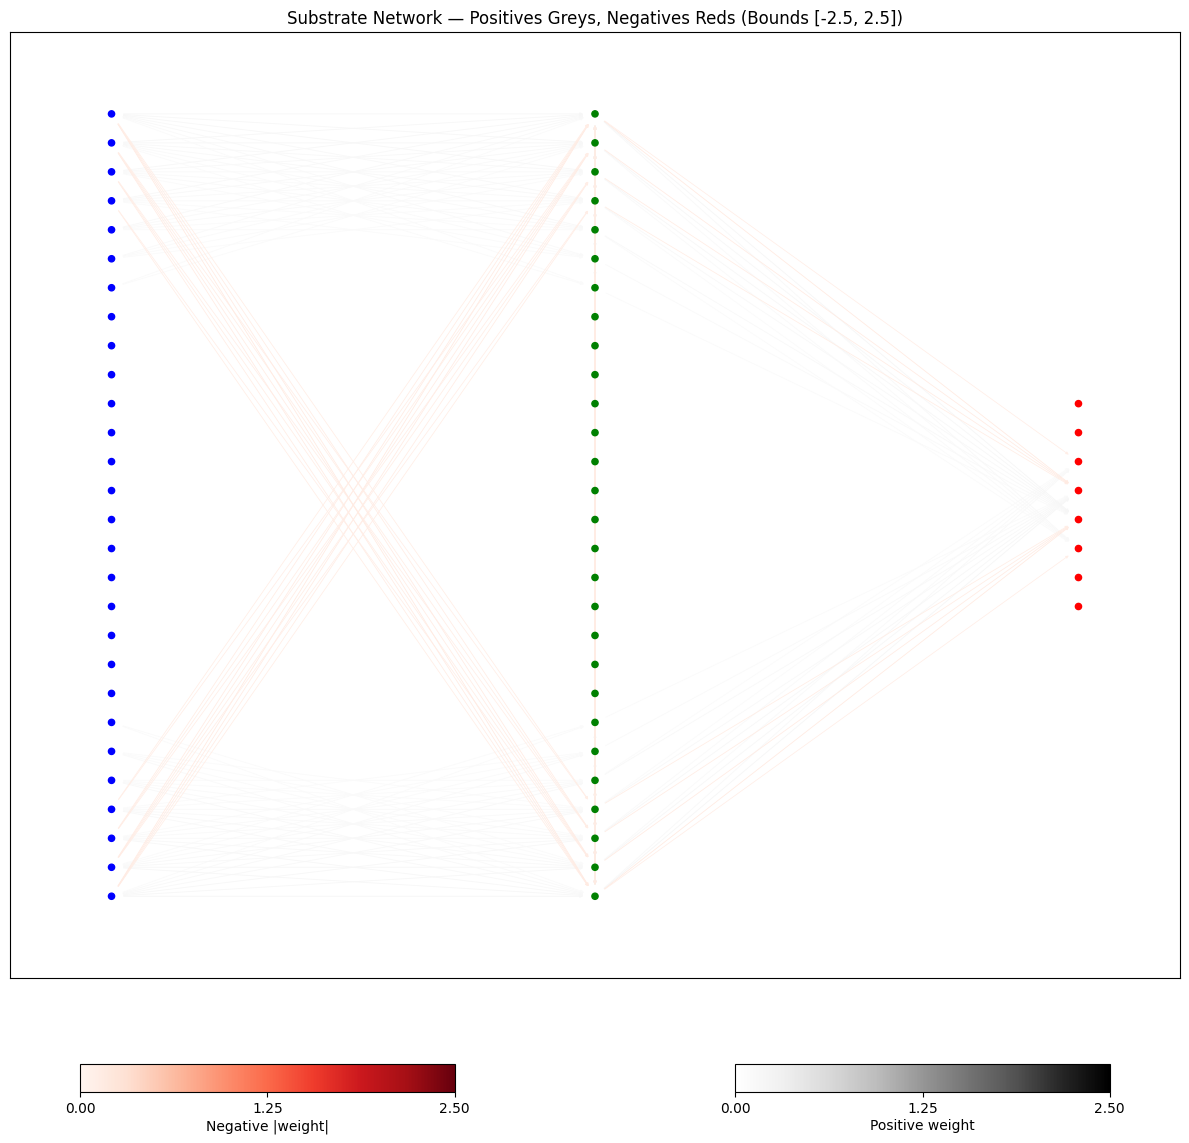

Visualization saved to: output/ant/topology/nn_manual_simple.svg
Successfully saved coordinates to: output/ant/coordinates/manual_simple_io.csv


save to output/ant
initializing
initializing finished
start compile
compile finished, cost time: 32.057206s
Generation: 1, Cost time: 5684.90ms
 	fitness: valid cnt: 600, max: 51.0423, min: -114.5152, mean: -16.7415, std: 55.3185

	node counts: max: 24, min: 22, mean: 23.08
 	conn counts: max: 78, min: 56, mean: 73.40
 	species: 47, [30, 31, 11, 6, 9, 30, 3, 40, 17, 5, 4, 19, 26, 3, 30, 25, 22, 16, 22, 6, 24, 7, 19, 4, 2, 37, 4, 25, 4, 6, 14, 1, 4, 5, 1, 5, 1, 3, 4, 6, 9, 6, 19, 20, 2, 7, 6]

Generation: 2, Cost time: 5652.52ms
 	fitness: valid cnt: 600, max: 52.9254, min: -104.4375, mean: 34.9525, std: 28.8373

	node counts: max: 25, min: 21, mean: 23.00
 	conn counts: max: 79, min: 38, mean: 69.81
 	species: 50, [84, 40, 23, 10, 14, 9, 11, 4, 7, 16, 8, 10, 8, 5, 12, 6, 8, 11, 4, 14, 10, 6, 14, 3, 17, 3, 5, 17, 6, 13, 6, 15, 12, 12, 19, 15, 7, 10, 8, 7, 3, 9, 18, 2, 8, 5, 2, 5, 13, 26]

Generation: 3, Cost time: 5654.92ms
 	fitness: valid cnt: 600, max: 53.0383, min: -102.2680, mean: 

compute_ms,▁▁▂▂▂▄▃▄▃▃▂▂▂▅▃▅▅▃▃▄▅▅▄▄▆▇██▇▆▆█▇██▆▇███
compute_ms_pop,▂▂▁▃▄▄▄▂▂▄▃▅▄▄▃▃▄▃▅▅▆▆▇▇██▆██▇▅▆▅█▇██▆█▆
fitness_max,▁▁▁▁▁▆▆▇▇▇▇▇▇▆▇█▆▇▇▇█▇█▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇█
fitness_mean,▆▆▁▆▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████▇█▇▇██▇█
fitness_min,▂▁▅▁▃▄▇▁▃▄▃▂▃▅▆▅▆▃▅▆▃▃▃▇▆▂▃█▄▂▇▆▃▄▇▂▂▃▅▂
fitness_std,▃▃▆▅▂▂▁▁▂▂▅▅▆▅▆▇▆▆▇▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▅▆▅▆▆█
generation,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
compute_ms,5750.42391
compute_ms_pop,9.58404
fitness_max,142.86084
fitness_mean,53.13051


Total reward:  98.59057


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_manual_randomized.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_manual_randomized.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 1792 potential connections.
Visualizing 880 connections. Excluded loops. Weight threshold: 0.1


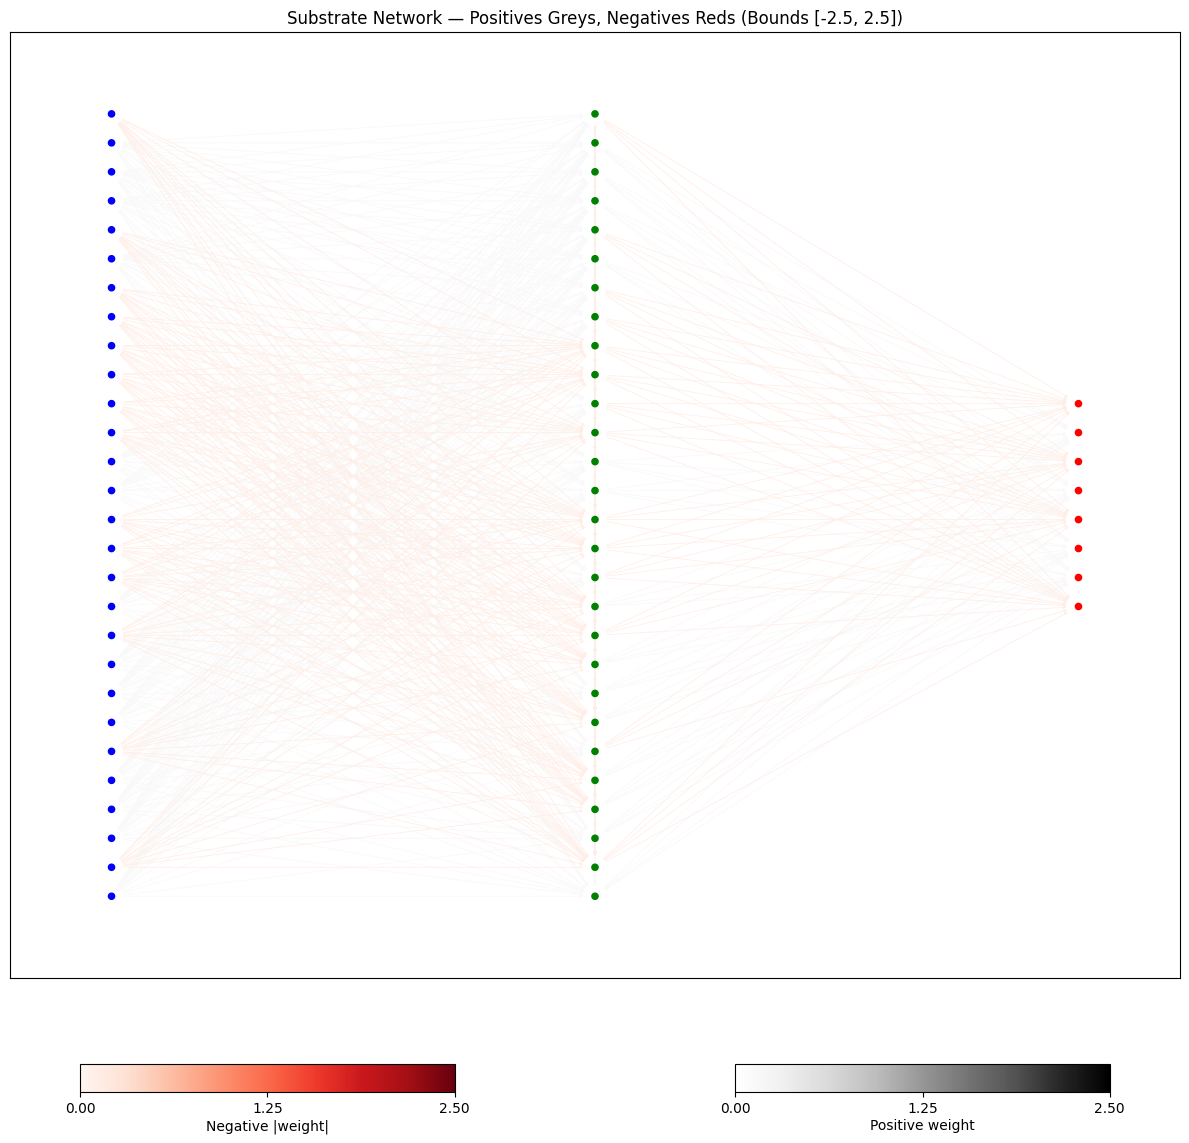

Visualization saved to: output/ant/topology/nn_manual_randomized.svg
Successfully saved coordinates to: output/ant/coordinates/manual_randomized_io.csv


save to output/ant
initializing
initializing finished
start compile
compile finished, cost time: 32.606692s
Generation: 1, Cost time: 5799.12ms
 	fitness: valid cnt: 600, max: 51.0944, min: -118.2252, mean: -10.9474, std: 53.8453

	node counts: max: 32, min: 30, mean: 31.08
 	conn counts: max: 152, min: 124, mean: 146.57
 	species: 42, [30, 22, 30, 10, 7, 33, 36, 10, 4, 1, 7, 3, 25, 10, 7, 29, 17, 20, 32, 24, 3, 25, 5, 9, 2, 11, 23, 26, 30, 21, 10, 11, 6, 6, 4, 4, 14, 2, 9, 4, 6, 12]

Generation: 2, Cost time: 5733.28ms
 	fitness: valid cnt: 600, max: 51.8743, min: -115.1704, mean: 38.9369, std: 20.7979

	node counts: max: 33, min: 29, mean: 31.05
 	conn counts: max: 152, min: 99, mean: 143.80
 	species: 48, [153, 4, 7, 10, 13, 11, 14, 15, 1, 1, 11, 12, 7, 7, 11, 6, 12, 4, 7, 10, 16, 19, 16, 21, 10, 4, 2, 3, 10, 4, 15, 21, 12, 10, 11, 3, 5, 14, 4, 4, 1, 1, 4, 17, 13, 12, 9, 23]

Generation: 3, Cost time: 5743.64ms
 	fitness: valid cnt: 600, max: 52.0791, min: -98.8633, mean: 39.7579, s

compute_ms,▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄█▅▄▇▇█▆▅▃▄▃▆▃▂▂▂▂▁▁▁▁▁
compute_ms_pop,▃▃▃▃▃▄▃▃▄▄▄▄▃▄▄▅▅▅█▇▃▃▅▅▅▆▃█▂▇▂▂▂▁▂▂▁▁▁▁
fitness_max,▁▆▃▅▂▂▄▆▇▄▇█▆▆▅██▇▆█▇▆█▆▇▇▂▂▂▂▂▂▂▂▂▂▂▂▃▂
fitness_mean,▆▆▄▆▅▁▄▅▄▄▅▃▇▇▂▆█▇██▇▆▇▆▆▇▇▆█▇▅▇▅▃▆▇▆▇▅▆
fitness_min,▃▃▃▄▅▄▄▄▃▃▄▁▁▄▃▄▃▃▄▃▄▃▅▃▃▃▄▅▃▄▅▅█▄▄▃▃▄▄▅
fitness_std,▄▅▂█▅▅▄▅▇▆▆▆▄▇▃▄▂▆▃▁▆▅▅▅▇▅▆▆▇▇▄▄▃▅▃▄▅▄▄▄
generation,▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
compute_ms,5594.63
compute_ms_pop,9.32438
fitness_max,68.91483
fitness_mean,42.42854


Total reward:  243.42102


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/video/agent_manual_mapping.mp4
Visualizing CPPN. Saving to output/ant/topology/cppn_manual_mapping.svg.
Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 1792 potential connections.
Visualizing 305 connections. Excluded loops. Weight threshold: 0.1


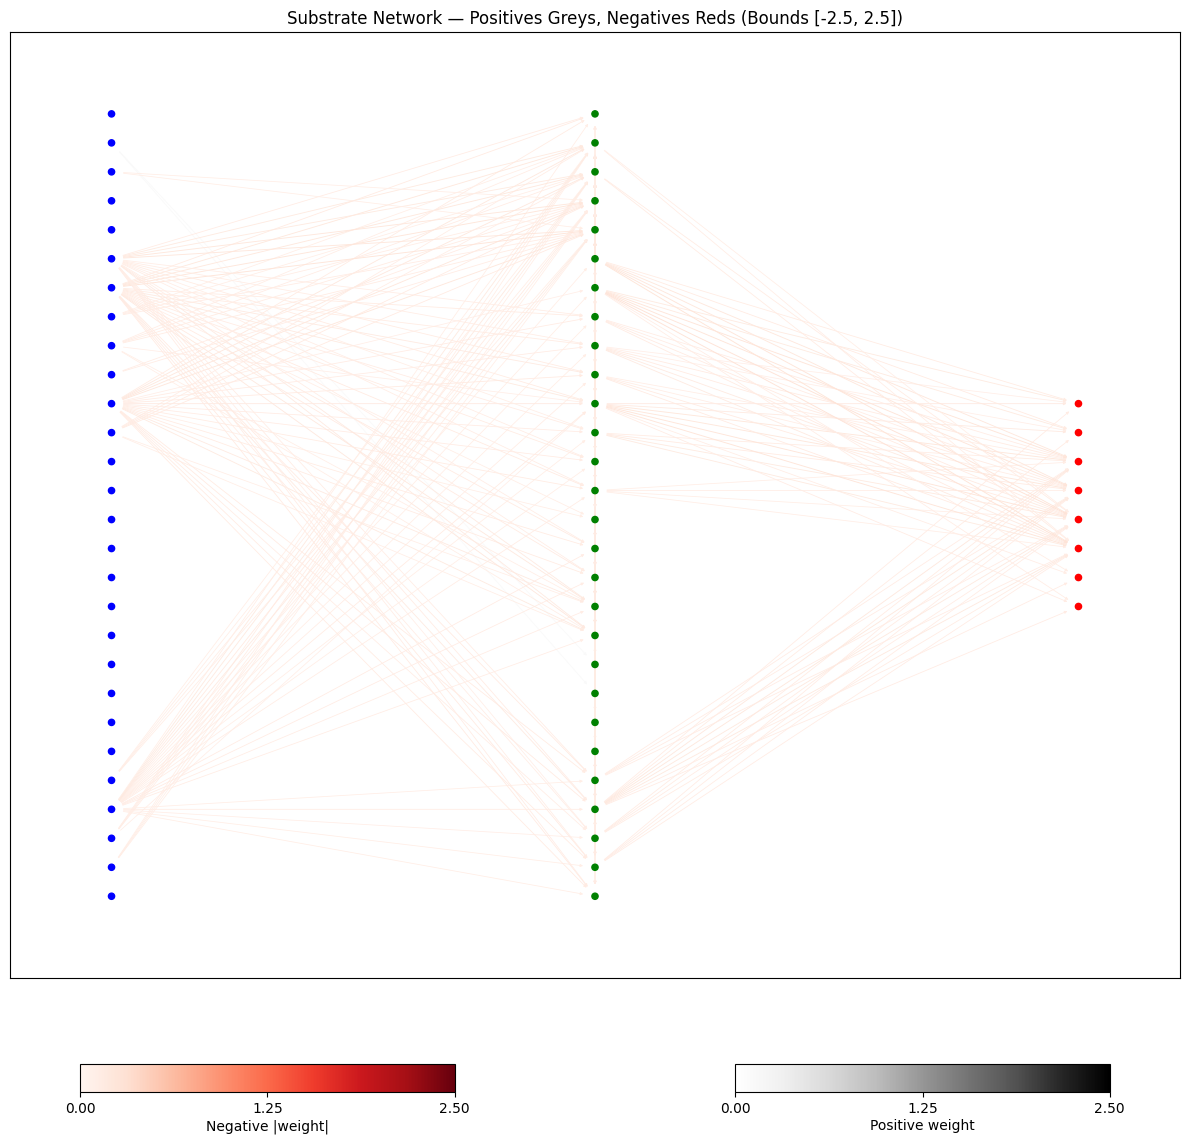

Visualization saved to: output/ant/topology/nn_manual_mapping.svg
Successfully saved coordinates to: output/ant/coordinates/manual_mapping_io.csv


save to output/ant
initializing
initializing finished
start compile
compile finished, cost time: 32.085507s
Generation: 1, Cost time: 5480.92ms
 	fitness: valid cnt: 600, max: 54.7223, min: -124.6351, mean: -35.7351, std: 60.4328

	node counts: max: 14, min: 12, mean: 13.08
 	conn counts: max: 24, min: 10, mean: 20.55
 	species: 50, [80, 75, 21, 25, 4, 4, 7, 11, 32, 8, 30, 7, 6, 1, 32, 15, 11, 1, 5, 29, 7, 9, 2, 2, 2, 2, 6, 7, 1, 6, 7, 4, 1, 4, 4, 1, 3, 18, 9, 1, 6, 2, 8, 2, 2, 2, 7, 5, 5, 61]

Generation: 2, Cost time: 5469.94ms
 	fitness: valid cnt: 600, max: 51.5028, min: -124.9766, mean: 13.2174, std: 52.9462

	node counts: max: 15, min: 12, mean: 13.15
 	conn counts: max: 26, min: 1, mean: 19.69
 	species: 50, [32, 7, 12, 1, 8, 5, 1, 25, 7, 9, 5, 44, 2, 7, 4, 7, 5, 4, 2, 1, 5, 5, 2, 4, 1, 2, 3, 2, 20, 10, 19, 3, 1, 6, 3, 15, 1, 12, 2, 29, 8, 24, 54, 1, 8, 4, 18, 6, 11, 133]

Generation: 3, Cost time: 5471.16ms
 	fitness: valid cnt: 600, max: 52.0520, min: -124.2881, mean: 24.0221,

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7f8abe8e6c20>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f8574193a00, execution_count=16 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f8574192830, raw_cell="for data_label, data_dict in substrates.items():
 .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/andi/Dokumente/Bachelorarbeit/dim_tuning/main.ipynb#X50sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
for data_label, data_dict in substrates.items():
    for method_label, method_dict in data_dict.items():

        active_substrate = substrates[data_label][method_label]["substrate"]
        evol_algorithm = create_evol_algorithm(substrate=active_substrate)

        initial_cppn_layers = config["algorithm"]["genome"]["cppn_init_hidden_layers"](active_substrate.query_coors.shape[1])
        print("Intial CPPN Layers:", initial_cppn_layers)
        substrate_dimensions = int(active_substrate.query_coors.shape[1]/2)

        wanbd_name = f"{env_name}_{data_label}_{method_label}_{substrate_dimensions}d"
        wandb_tags = [config["substrate"]["hidden_layer_type"], env_name, data_label, method_label, f"{config['substrate']['hidden_depth']}_hl", f"{config['algorithm']['neat']['pop_size']}pop", f"{config['environment']['backend']}"]

        wandb.init(
            name=wanbd_name,
            project="substrate_dims",
            tags=wandb_tags,
            config=config  
        )

        wandb.config.update(
            {
                "substrate": {
                    "obs_size": obs_size,
                    "act_size": act_size,
                    "num_queries": active_substrate.query_coors.shape[0],
                    "query_dim": active_substrate.query_coors.shape[1],
                    },
                "algorithm": {
                    "neat": {
                        "num_inputs": evol_algorithm.num_inputs,
                        },
                    "genome": {
                        "cppn_init_hidden_layers": initial_cppn_layers,
                        },
                    },
            },
        )

        pipeline = CustomPipeline(
            algorithm=evol_algorithm,
            problem=env_problem,
            seed=config["experiment"]["seed"],
            generation_limit=config["pipeline"]["generation_limit"],
            fitness_target=config["pipeline"]["fitness_target"],
            is_save=True,
            save_dir=config["experiment"]["output_dir"],
        )

        init_state = pipeline.setup()
        state = pipeline.auto_run(state=init_state)

        print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

        wandb.finish()

        state_for_show = state[0] if isinstance(state, tuple) else state

        # Transform the best genome into network parameters
        best_genome = pipeline.best_genome

        # Built-in show method to produce and save a video of the agent
        pipeline.show(
            state=state_for_show,
            best=best_genome,
            output_type="mp4",
            save_path=f"{OUTPUT_DIR}/video/agent_{data_label}_{method_label}.mp4",
        )

        # All coordinates are needed for visualization
        input_coors = substrates[data_label][method_label]["input_coors"]
        hidden_coors = substrates[data_label][method_label]["hidden_coors"]
        output_coors = substrates[data_label][method_label]["output_coors"]

        # Visualizes the CPPN
        visualize_cppn(
            pipeline=pipeline, 
            state=state, 
            save_path=f"{OUTPUT_DIR}/topology/cppn_{data_label}_{method_label}.svg"
            )
        # Visualizes a representation of the neural network in 2D space
        visualize_nn(
            pipeline=pipeline, 
            state=state, 
            save_path=f"{OUTPUT_DIR}/topology/nn_{data_label}_{method_label}.svg", 
            substrate=active_substrate, 
            input_coors=input_coors, 
            hidden_coors=hidden_coors, 
            output_coors=output_coors, 
            hidden_depth=config["substrate"]["hidden_depth"], 
            max_weight=config["algorithm"]["hyperneat"]["max_weight"], 
            )
        
        # all input and output coordinates are logged for further analysis
        log_coors = input_coors
        for coor in hidden_coors:
            log_coors.append(coor)
        for coor in output_coors:
            log_coors.append(coor)
        save_coordinates_to_csv(
            coordinates=log_coors,
            filepath=f"{OUTPUT_DIR}/coordinates/{data_label}_{method_label}_io.csv",
        )
